In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_ace_val(temp_list):
    sum_ar = np.zeros((2**len(temp_list), len(temp_list)))
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_ar.shape[0]/half_len/2)):
            sum_ar[rep*2**n : rep*2**n+half_len, i] = 1
            sum_ar[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # Only return values that are valid (<=21)
    return list(set([int(s) for s in np.sum(sum_ar, axis=1) if s<=21]))
def ace_val(num_aces):
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_val(temp_list)

In [3]:
def make_dck(num_dcks, cd_type):
    new_dck = []
    for i in range(num_dcks):
        for j in range(4):
            new_dck.extend(cd_type)
    random.shuffle(new_dck)
    return new_dck

In [4]:
def total_up(hand):
    aces = 0
    total = 0
    
    for cd in hand:
        if cd != 'A':
            total += cd
        else:
            aces += 1
    
    ace_value_list = ace_val(aces)
    final_totals = [i+total for i in ace_value_list if i+total<=21]
    
    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)

In [5]:
stacks = 50000
plrs = 3
num_dcks = 3

cd_type = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_cd_feature = []
plr_cd_feature = []
plr_results = []

In [6]:
for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cds = make_dck(num_dcks, cd_type)
    while len(dealer_cds) > 20:
        
        curr_plr_results = np.zeros((3,plrs))
        
        dealer_hd = []
        plrs_hand = [[] for plr in range(plrs)]

        # Deal FIRST card
        for plr, hand in enumerate(plrs_hand):
            plrs_hand[plr].append(dealer_cds.pop(0))
        dealer_hd.append(dealer_cds.pop(0))
        # Deal SECOND card
        for plr, hand in enumerate(plrs_hand):
            plrs_hand[plr].append(dealer_cds.pop(0))
        dealer_hd.append(dealer_cds.pop(0))

        # Dealer checks for 21
        if set(dealer_hd) == blackjack:
            for plr in range(plrs):
                if set(plrs_hand[plr]) != blackjack:
                    curr_plr_results[0,plr] = -1
                else:
                    curr_plr_results[0,plr] = 0
        else:
            for plr in range(plrs):
                # Players check for 21
                if set(plrs_hand[plr]) == blackjack:
                    curr_plr_results[0,plr] = 1
                else:
                    # Hit randomly, check for busts
                    while (random.random() >= 0.5) and (total_up(plrs_hand[plr]) != 21):
                        plrs_hand[plr].append(dealer_cds.pop(0))
                        if total_up(plrs_hand[plr]) > 21:
                            curr_plr_results[0,plr] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hd) < 17:
            dealer_hd.append(dealer_cds.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hd) > 21:
            for plr in range(plrs):
                if curr_plr_results[0,plr] != -1:
                    curr_plr_results[0,plr] = 1
        else:
            for plr in range(plrs):
                if total_up(plrs_hand[plr]) > total_up(dealer_hd):
                    if total_up(plrs_hand[plr]) <= 21:
                        curr_plr_results[0,plr] = 1
                elif total_up(plrs_hand[plr]) == total_up(dealer_hd):
                    curr_plr_results[0,] = 0
                else:
                    curr_plr_results[0,plr] = -1
        dealer_cd_feature.append(dealer_hd[0])
        plr_cd_feature.append(plrs_hand)
        plr_results.append(list(curr_plr_results[0]))

In [7]:
model_df = pd.DataFrame()
model_df['dealer_cd'] = dealer_cd_feature
model_df['plr_total_initial'] = [total_up(i[0][0:2]) for i in plr_cd_feature]
model_df['Y'] = [i[0] for i in plr_results]

lose = []
for i in model_df['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df['lose'] = lose

has_ace = []
for i in plr_cd_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df['has_ace'] = has_ace

dealer_cd_num = []
for i in model_df['dealer_cd']:
    if i=='A':
        dealer_cd_num.append(11)
    else:
        dealer_cd_num.append(i)
model_df['dealer_cd_num'] = dealer_cd_num
sum(pd.DataFrame(plr_results)[0].value_counts())
pd.DataFrame(plr_results)[0].value_counts()

-1.0    376508
 1.0    200022
 0.0     82795
Name: 0, dtype: int64

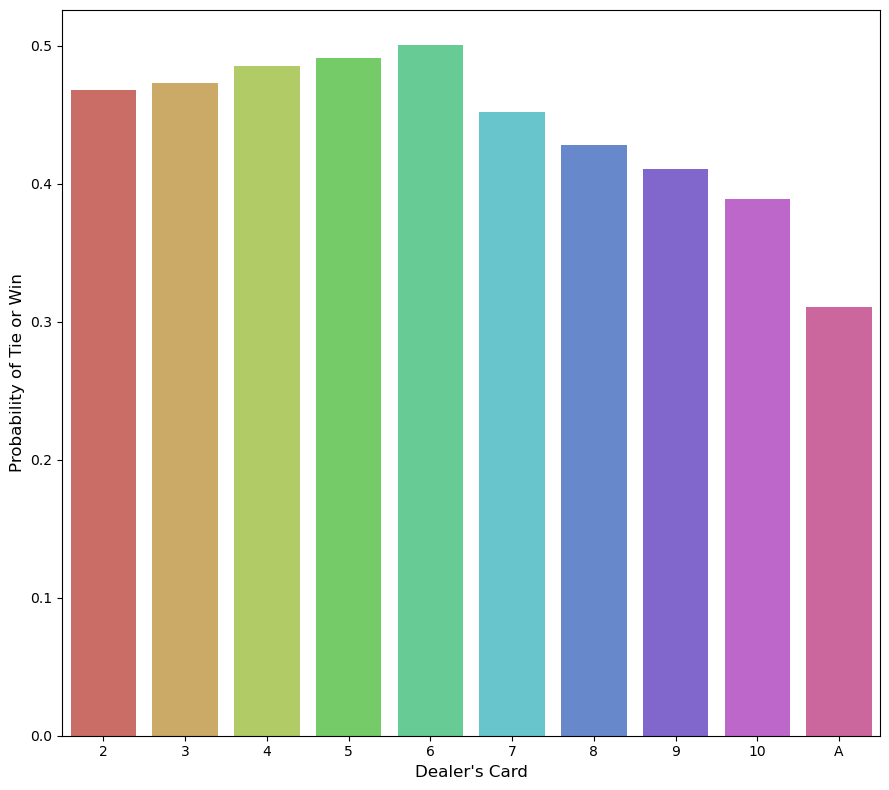

In [27]:
data = 1 - (model_df.groupby(by='dealer_cd').sum()['lose'] /\
            model_df.groupby(by='dealer_cd').count()['lose'])

fig, ax = plt.subplots(figsize=(9,8))
ax = sns.barplot(x=data.index, 
                 y=data.values
                 palette='hls')
ax.set_xlabel("Dealer's Card",fontsize=12)
ax.set_ylabel("Probability of Tie or Win",fontsize=12)

plt.tight_layout()
plt.savefig(fname='dealer_cd_probs', dpi=180)

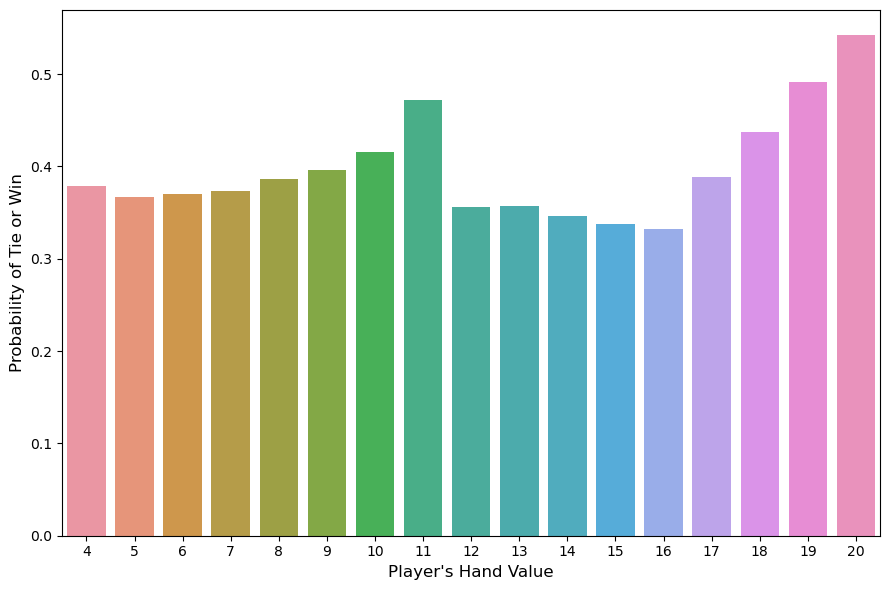

In [29]:
data = 1 - (model_df.groupby(by='plr_total_initial').sum()['lose'] /\
            model_df.groupby(by='plr_total_initial').count()['lose'])

fig, ax = plt.subplots(figsize=(9,6))
ax = sns.barplot(x=data[:-1].index,
                 y=data[:-1].values)
ax.set_xlabel("Player's Hand Value",fontsize=12)
ax.set_ylabel("Probability of Tie or Win",fontsize=12)

plt.tight_layout()
plt.savefig(fname='plr_hand_probs', dpi=180)

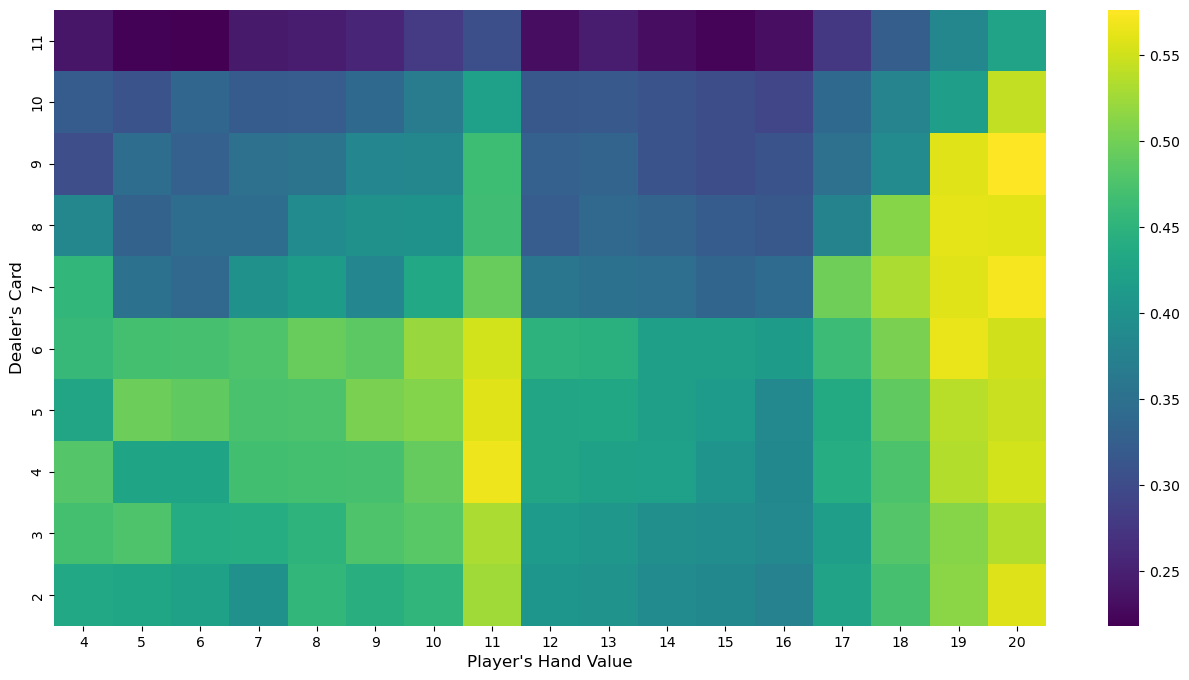

In [30]:
model_df.groupby(by='has_ace').sum()['lose'] / model_df.groupby(by='has_ace').count()['lose']
pivot_data = model_df[model_df['plr_total_initial'] != 21]

losses_pivot = pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_cd_num'],
                              columns = ['plr_total_initial'],
                              aggfunc = np.sum)

games_pivot =  pd.pivot_table(pivot_data, values='lose', 
                              index=['dealer_cd_num'],
                              columns = ['plr_total_initial'],
                              aggfunc = 'count')

heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(16,8))
sns.heatmap(heat_data, square=False, cmap="viridis");

ax.set_xlabel("Player's Hand Value",fontsize=12)
ax.set_ylabel("Dealer's Card",fontsize=12)

plt.savefig(fname='heat_map_random', dpi=180)

In [11]:
stacks = 50000
plrs = 3
num_dcks = 3

cd_type = ['A',2,3,4,5,6,7,8,9,10,10,10,10]

dealer_cd_feature = []
plr_cd_feature = []
plr_results = []

In [12]:
for stack in range(stacks):
    blackjack = set(['A',10])
    dealer_cds = make_dck(num_dcks, cd_type)
    while len(dealer_cds) > 20:
        
        curr_plr_results = np.zeros((3,plrs))
        
        dealer_hd = []
        plrs_hand = [[] for plr in range(plrs)]

        # Deal FIRST card
        for plr, hand in enumerate(plrs_hand):
            plrs_hand[plr].append(dealer_cds.pop(0))
        dealer_hd.append(dealer_cds.pop(0))
        # Deal SECOND card
        for plr, hand in enumerate(plrs_hand):
            plrs_hand[plr].append(dealer_cds.pop(0))
        dealer_hd.append(dealer_cds.pop(0))

        # Dealer checks for 21
        if set(dealer_hd) == blackjack:
            for plr in range(plrs):
                if set(plrs_hand[plr]) != blackjack:
                    curr_plr_results[0,plr] = -1
                else:
                    curr_plr_results[0,plr] = 0
        else:
            for plr in range(plrs):
                # Players check for 21
                if set(plrs_hand[plr]) == blackjack:
                    curr_plr_results[0,plr] = 1
                else:
                    # Hit only when we know we will not bust
                    while total_up(plrs_hand[plr]) <= 11:
                        plrs_hand[plr].append(dealer_cds.pop(0))
                        if total_up(plrs_hand[plr]) > 21:
                            curr_plr_results[0,plr] = -1
                            break
        
        # Dealer hits based on the rules
        while total_up(dealer_hd) < 17:
            dealer_hd.append(dealer_cds.pop(0))
        # Compare dealer hand to players hand but first check if dealer busted
        if total_up(dealer_hd) > 21:
            for plr in range(plrs):
                if curr_plr_results[0,plr] != -1:
                    curr_plr_results[0,plr] = 1
        else:
            for plr in range(plrs):
                if total_up(plrs_hand[plr]) > total_up(dealer_hd):
                    if total_up(plrs_hand[plr]) <= 21:
                        curr_plr_results[0,plr] = 1
                elif total_up(plrs_hand[plr]) == total_up(dealer_hd):
                    curr_plr_results[0,plr] = 0
                else:
                    curr_plr_results[0,plr] = -1
        dealer_cd_feature.append(dealer_hd[0])
        plr_cd_feature.append(plrs_hand)
        plr_results.append(list(curr_plr_results[0]))

model_df_smart = pd.DataFrame()
model_df_smart['dealer_cd'] = dealer_cd_feature
model_df_smart['plr_total_initial'] = [total_up(i[0][0:2]) for i in plr_cd_feature]
model_df_smart['Y'] = [i[0] for i in plr_results]

lose = []
for i in model_df_smart['Y']:
    if i == -1:
        lose.append(1)
    else:
        lose.append(0)
model_df_smart['lose'] = lose

has_ace = []
for i in plr_cd_feature:
    if ('A' in i[0][0:2]):
        has_ace.append(1)
    else:
        has_ace.append(0)
model_df_smart['has_ace'] = has_ace

dealer_cd_num = []
for i in model_df_smart['dealer_cd']:
    if i=='A':
        dealer_cd_num.append(11)
    else:
        dealer_cd_num.append(i)
model_df_smart['dealer_cd_num'] = dealer_cd_num

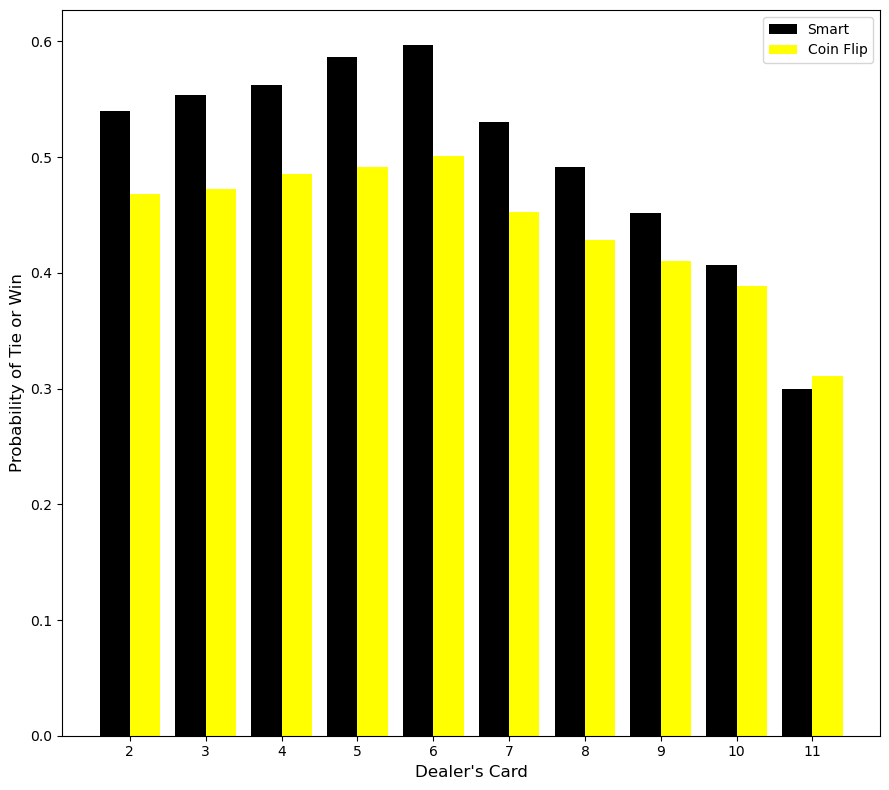

In [32]:
data_smart = 1 - (model_df_smart.groupby(by='dealer_cd_num').sum()['lose'] /\
                  model_df_smart.groupby(by='dealer_cd_num').count()['lose'])
data_random = 1 - (model_df.groupby(by='dealer_cd_num').sum()['lose'] /\
                   model_df.groupby(by='dealer_cd_num').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart
data['random'] = data_random

fig, ax = plt.subplots(figsize=(9,8))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='black', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='yellow', width=0.4, label='Coin Flip')
ax.set_xlabel("Dealer's Card",fontsize=12)
ax.set_ylabel("Probability of Tie or Win",fontsize=12)
plt.xticks(np.arange(2, 12, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='dealer_cd_probs_smart', dpi=180)

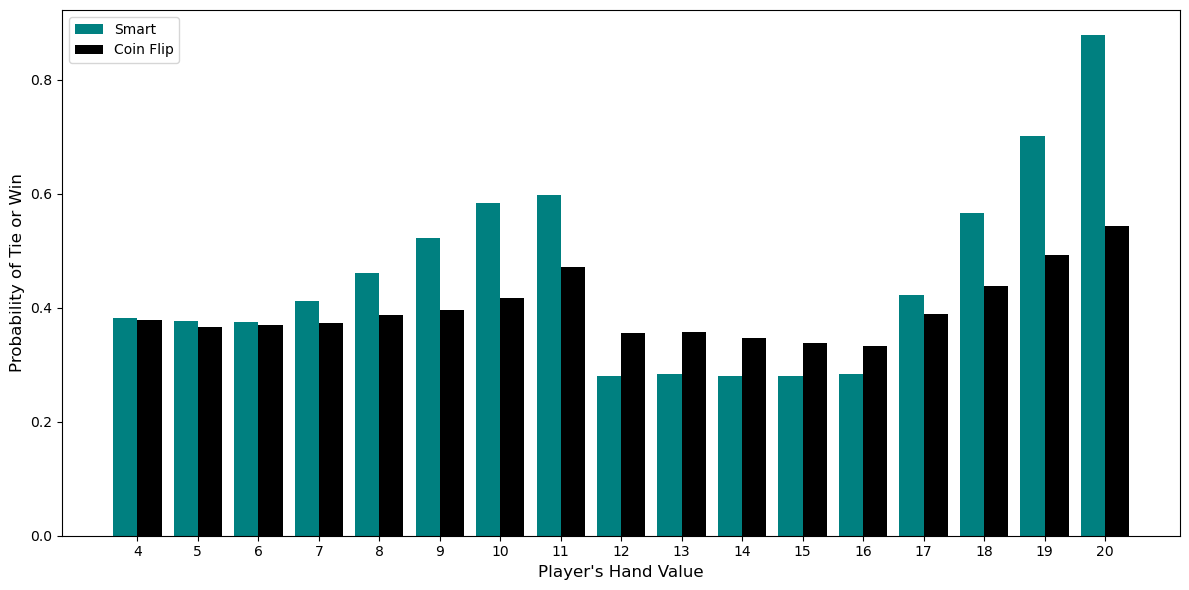

In [35]:
data_smart = 1 - (model_df_smart.groupby(by='plr_total_initial').sum()['lose'] /\
                  model_df_smart.groupby(by='plr_total_initial').count()['lose'])
data_random = 1 - (model_df.groupby(by='plr_total_initial').sum()['lose'] /\
                   model_df.groupby(by='plr_total_initial').count()['lose'])

data = pd.DataFrame()
data['smart'] = data_smart[:-1]
data['random'] = data_random[:-1]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x=data.index-0.2, height=data['smart'].values, color='teal', width=0.4, label='Smart')
ax.bar(x=data.index+0.2, height=data['random'].values, color='black', width=0.4, label='Coin Flip')
ax.set_xlabel("Player's Hand Value",fontsize=12)
ax.set_ylabel("Probability of Tie or Win",fontsize=12)
plt.xticks(np.arange(4, 21, 1.0))

plt.legend()
plt.tight_layout()
plt.savefig(fname='plr_hand_probs_smart', dpi=180)